# Imports

In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
import altair as alt

# Dask
import dask.dataframe as dd

# pyarrow and feather
import pyarrow.feather as feather
import pyarrow.dataset as ds
import pyarrow as pa
import pyarrow.parquet as pq
import rpy2_arrow.pyarrow_rarrow as pyra

In [2]:
%load_ext rpy2.ipython
%load_ext memory_profiler

C:\Users\ibaad\.conda\envs\525_2022\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


# 1. Teamwork Contract
The teamwork contract for our team, group 7, can be found [here](https://docs.google.com/document/d/1u4e5Z5C-uwTTSvCEyOYy-I30Fb8OEPYM6frM0NBEVVc/edit).

# 2. Create repository and project structure
The repository URL: https://github.com/UBC-MDS/DSCI525-Group7

# 3. Downloading the data

Using Python **requests** Library

We are using article id #14096681, which contains the data of **Daily rainfall over NSW, Australia.**

In [3]:
# Setup
article_id = 14096681  
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "rainfall/"

Review the files within the article:

In [4]:
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)  # this contains all the articles data, feel free to check it out
files = data["files"]             # this is just the data about the files, which is what we want
files

[{'id': 26579150,
  'name': 'daily_rainfall_2014.png',
  'size': 58863,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e'},
 {'id': 26579171,
  'name': 'environment.yml',
  'size': 192,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34'},
 {'id': 26586554,
  'name': 'README.md',
  'size': 5422,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c'},
 {'id': 26766812,
  'name': 'data.zip',
  'size': 814041183,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26766812',
  'supplied_md5': 'b517383f76e77bd03755a63a8f

# 3.1 Unzipping the data

In [5]:
%%time

files_to_dl = ["data.zip"]  
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: total: 9.73 s
Wall time: 1min


In [6]:
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

In [7]:
%ls -ltr rainfall/

Invalid switch - "".


# Comparison of Performance on Different Machines

The summary of all team members' time taken to unzip the data is recorded below. Each team member's Operating System, RAM, Processor and SSD are also recorded to check if they have any effect on the time taken.

| Team Member | Operating System | RAM | Processor | Is SSD | Time Taken |
|-------------|------------------|-----|-----------|--------|------------|
| Jessie | Windows 10 Education | 16GB | Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz 1.99 GHz | Yes | CPU times: total: 8.48s <br> Wall time: 1min 35s |
| Adrianne | Windows 10 Pro | 16GB | Intel(R) Core(TM) i7-1165G7 @ 2.80GHz 2.80 GHz | Yes | CPU times: total: 6.23s <br> Wall time: 1min 7s |
| Rada | Macbook Pro 2013 15" | 16GB | 2.3 GHz Intel Core i7 | No | CPU times: total: 10.4 s<br>Wall time: 3min 5s |
| Moid | Windows 11 Education | 12GB | 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz 1.38 GHz | Yes | CPU times: total: 9.73s <br> Wall time: 1min |

Macbook Pro took palpably longer than the rest for this process. Would be curious to review the reason.

# 4. Combining data CSVs

- Combine data CSVs into a single CSV using pandas.

- When combining the CSV files, add an extra column called "model" that identifies the model. Tip 1: you can get this column populated from the file name, eg: for file name "SAM0-UNICON_daily_rainfall_NSW.csv", the model name is SAM0-UNICON Tip 2: Remember how we added year when we combined airline CSVs. Tip 3: You can use regex generator.

_Note: There is a file called observed_daily_rainfall_SYD.csv in the data folder that you downloaded. Make sure you exclude this file (programmatically or just take out that file from folder) before you combine CSVs. We will use this file in our next milestone._

- Compare run times on different machines within your team and summarize your observations.
Warning: Some of you might not be able to do it on your laptop. It's fine if you're unable to do it. Just make sure you discuss the reasons why you might not have been able to run this on your laptop.

Let's first view the data and the columns:

In [8]:
%%time

df_1 = pd.read_csv(output_directory+"/MPI-ESM-1-2-HAM_daily_rainfall_NSW.csv")
df_2 = pd.read_csv(output_directory+"/CMCC-CM2-SR5_daily_rainfall_NSW.csv")
df_3 = pd.read_csv(output_directory+"/SAM0-UNICON_daily_rainfall_NSW.csv")

CPU times: total: 12.8 s
Wall time: 13.1 s


Even loading three of the individual files is taking a little time.

In [9]:
df_1.head(2)

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day)
0,1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13
1,1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13


In [10]:
df_2.head(2)

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day)
0,1889-01-01 12:00:00,-35.811518,-34.86911,140.625,141.875,0.000424
1,1889-01-02 12:00:00,-35.811518,-34.86911,140.625,141.875,0.006158


In [11]:
df_3.head(2)

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day)
0,1889-01-01 12:00:00,-35.811518,-34.86911,140.625,141.875,3.045650e-13
1,1889-01-02 12:00:00,-35.811518,-34.86911,140.625,141.875,3.572392e-04


In [12]:
df_3.tail(2)

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day)
3541151,2014-12-30 12:00:00,-30.157068,-29.21466,153.125,154.375,8.541592
3541152,2014-12-31 12:00:00,-30.157068,-29.21466,153.125,154.375,68.117489


In [13]:
%%time

files = glob.glob('./rainfall/*NSW.csv')
df = pd.concat((pd.read_csv(file, index_col=0)
                .assign(model=re.findall(r'/([^_]*)', file)[0])
                for file in files)
              )
df.to_csv("rainfall/combined_data.csv")

CPU times: total: 13min 42s
Wall time: 14min 11s


**For Windows user:**   
Windows users will run into an index error when running the code above to combine the CSVs.   
This can be solved by adding a ./ to the filename as below.

In [14]:
%%time
%memit
files = glob.glob('./rainfall/*NSW.csv')
df = pd.concat((pd.read_csv(file, index_col=0)
                .assign(model=file.strip('./rainfall\\').split('_')[0])
                for file in files)
              )
df.to_csv("rainfall/combined_data.csv")

peak memory: 4090.99 MiB, increment: 0.50 MiB
CPU times: total: 13min 24s
Wall time: 13min 58s


Wow, this felt like an eternity!

Let's take a look at the combined file, see if head and tail are as we expect them to be:

In [15]:
df.head()

,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
time,,,,,,
1889-01-01 12:00:00,-36.25,-35.0,140.625,142.5,3.293256e-13,ACCESS-CM2
1889-01-02 12:00:00,-36.25,-35.0,140.625,142.5,0.000000e+00,ACCESS-CM2
1889-01-03 12:00:00,-36.25,-35.0,140.625,142.5,0.000000e+00,ACCESS-CM2
1889-01-04 12:00:00,-36.25,-35.0,140.625,142.5,0.000000e+00,ACCESS-CM2
1889-01-05 12:00:00,-36.25,-35.0,140.625,142.5,1.047658e-02,ACCESS-CM2


In [16]:
df.tail()

,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
time,,,,,,
2014-12-27 12:00:00,-30.157068,-29.21466,153.125,154.375,0.554375,TaiESM1
2014-12-28 12:00:00,-30.157068,-29.21466,153.125,154.375,7.028577,TaiESM1
2014-12-29 12:00:00,-30.157068,-29.21466,153.125,154.375,0.234757,TaiESM1
2014-12-30 12:00:00,-30.157068,-29.21466,153.125,154.375,2.097459,TaiESM1
2014-12-31 12:00:00,-30.157068,-29.21466,153.125,154.375,0.548421,TaiESM1


## Comparison of Performance on Different Machines

The summary of all team members' time taken to combine the CSV's files is recorded below. Each team member's Operating System, RAM, Processor and SSD are also recorded to check if they have any effect on the time taken.

| Team Member | Operating System | RAM | Processor | Is SSD | Time Taken |
|-------------|------------------|-----|-----------|--------|------------|
| Jessie | Windows 10 Education | 16GB | Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz 1.99 GHz | Yes | peak memory: 800.19 MiB <br> increment: 0.00 MiB <br> CPU times: total: 8min 33s <br> Wall time: 8min 40s |
| Adrianne | Windows 10 Pro | 16GB | Intel(R) Core(TM) i7-1165G7 @ 2.80GHz 2.80 GHz | Yes | peak memory: 120.25 MiB <br> increment: 0.30 MiB <br> CPU times: total: 7min 26s <br> Wall time: 7min 31s |
| Rada | Macbook Pro 2013 15" | 16GB | 2.3 GHz Intel Core i7 | No | peak memory: 3939.19 MiB <br> increment: 0.10 MiB <br> CPU times: user 7min 14s, sys: 21.5 s, total: 7min 36s  <br> Wall time: 7min 47s |
| Moid | Windows 11 Education | 12GB | 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz 1.38 GHz | Yes | peak memory: 4090.99 MiB <br> increment: 0.50 MiB <br> CPU times: total: 13min 24s <br> Wall time: 14min 11s |

**Observations:**
Combining process is long in general at around 7-8 minutes, but quite consistent. Interesting to note the peak memory spikes on Macbook Pro and Windows i5 core machines.

# 5. Load the combined CSV to memory and perform a simple EDA

1. Investigate at least two of the following approaches to reduce memory usage while performing the EDA (e.g., value_counts).

- Changing dtype of your data
- Load just columns what we want
- Loading in chunks
- Dask

2. Compare run times on different machines within your team and summarize your observations.

**The EDA will be to use value_counts() to count the number of data points that came from each .csv file, as recorded in the model column of combined_data.csv.**

### 5.1 Load the Entire Dataframe to Memory Using Pandas (Baseline for Comparison)

In [17]:
%%time
%%memit

df_pandas = pd.read_csv("rainfall/combined_data.csv")
print(df_pandas["model"].value_counts())

MPI-ESM1-2-HR       5154240
TaiESM1             3541230
NorESM2-MM          3541230
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
SAM0-UNICON         3541153
FGOALS-f3-L         3219300
GFDL-CM4            3219300
GFDL-ESM4           3219300
EC-Earth3-Veg-LR    3037320
MRI-ESM2-0          3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM5-0           1609650
INM-CM4-8           1609650
KIOST-ESM           1287720
FGOALS-g3           1287720
MPI-ESM1-2-LR        966420
NESM3                966420
AWI-ESM-1-1-LR       966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64
peak memory: 10338.13 MiB, increment: 6442.66 MiB
CPU times: total: 2min 15s
Wall time: 2min 25s


**Observations**
>Our baseline approach is to use Pandas to load the entire data to memory. The above code loads the combined_data.csv to memory and performs a simple EDA to calculate counts of values in the "model" column. We see that the peak memory is 9060 MiB and the CPU and wall time is 1min 31s. We will explore some other approaches to see if we can reduce the time and memory usage.

### 5.2 Changing dtypes of data:

- We will attempt to read the numerical columns using float32 format

Memory comparison for format changes adapted from Lecture notes:

In [18]:
print(f"Memory usage with float64: {df[['lat_min','lat_max', 'lon_min', 'lon_max', 'rain (mm/day)']].memory_usage().sum() / 1e6:.2f} MB")
print(f"Memory usage with float32: {df[['lat_min','lat_max', 'lon_min', 'lon_max', 'rain (mm/day)']].astype('float32', errors='ignore').memory_usage().sum() / 1e6:.2f} MB")

Memory usage with float64: 2998.46 MB
Memory usage with float32: 1749.10 MB


In [19]:
df_float32 = df.copy()
df_float32[['lat_min','lat_max','lon_min', 'lon_max', 'rain (mm/day)']].astype('float32')

#saving the dataframe of float32 to file
df_float32.to_csv("rainfall/combined_data_float32.csv")

In [20]:
%%time
%%memit

#loading the float32 dataframe to memory and perform a simple EDA for value counts of model column
df_float32 = pd.read_csv("rainfall/combined_data_float32.csv")
print(df_float32["model"].value_counts())

MPI-ESM1-2-HR       5154240
TaiESM1             3541230
NorESM2-MM          3541230
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
SAM0-UNICON         3541153
FGOALS-f3-L         3219300
GFDL-CM4            3219300
GFDL-ESM4           3219300
EC-Earth3-Veg-LR    3037320
MRI-ESM2-0          3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM5-0           1609650
INM-CM4-8           1609650
KIOST-ESM           1287720
FGOALS-g3           1287720
MPI-ESM1-2-LR        966420
NESM3                966420
AWI-ESM-1-1-LR       966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64
peak memory: 12495.79 MiB, increment: 4995.49 MiB
CPU times: total: 2min 7s
Wall time: 2min 19s


**Observations:**
> When we changed the data type from float64 to float32 the memory usage reduced by nearly half. This is because float32 is stored as a 32-bit number, while float64 is stored as 64-bit number, which is twice as much memory as float32. With the EDA, we see that after converting dtypes to float 32, the peak memory usage decreased and the increment memory was halved. Both the CPU and wall time also decreased. Changing the dtype is effective in reducing the time and memory required to load data, and should be used when we have a large amount of data that does not require very high precision.


### 5.3 Dask:

- We will attempt to read dataframe using dask

In [21]:
%%time
%%memit
# Dask
df_dask = dd.read_csv('rainfall/combined_data.csv')
print(df_dask["model"].value_counts().compute())

MPI-ESM1-2-HR       5154240
TaiESM1             3541230
NorESM2-MM          3541230
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
SAM0-UNICON         3541153
FGOALS-f3-L         3219300
GFDL-CM4            3219300
GFDL-ESM4           3219300
EC-Earth3-Veg-LR    3037320
MRI-ESM2-0          3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM5-0           1609650
INM-CM4-8           1609650
KIOST-ESM           1287720
FGOALS-g3           1287720
MPI-ESM1-2-LR        966420
NESM3                966420
AWI-ESM-1-1-LR       966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64
peak memory: 5863.45 MiB, increment: 1263.75 MiB
CPU times: total: 1min 36s
Wall time: 37.4 s


**Observations:**
> Using a Dask dataframe is much faster and lighter on memory. Compared to loading the csv to pandas data frame, when we load the csv file to dask, the peak memory, increment memory, and wall time all reduced significantly when calling the value_counts() function. This is likely because dask partitioned the dataframe based on row index and did the calculation in parallel to improve the efficiency. Thus, for large-scale data calculation, we could use dask instead of pandas to improve the code efficiency with minimal syntax change.

### 5.4 Loading in Chunks:

- We will attempt to read dataframe in chunks

#### Chunksize = 10 million:

In [22]:
%%time
%%memit
counts = pd.Series(dtype=int)
for chunk in pd.read_csv("rainfall/combined_data.csv", chunksize=10_000_000):
    counts = counts.add(chunk["model"].value_counts(), fill_value=0)
print(counts.astype(int))

ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
AWI-ESM-1-1-LR       966420
BCC-CSM2-MR         3035340
BCC-ESM1             551880
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
CanESM5              551880
EC-Earth3-Veg-LR    3037320
FGOALS-f3-L         3219300
FGOALS-g3           1287720
GFDL-CM4            3219300
GFDL-ESM4           3219300
INM-CM4-8           1609650
INM-CM5-0           1609650
KIOST-ESM           1287720
MIROC6              2070900
MPI-ESM-1-2-HAM      966420
MPI-ESM1-2-HR       5154240
MPI-ESM1-2-LR        966420
MRI-ESM2-0          3037320
NESM3                966420
NorESM2-LM           919800
NorESM2-MM          3541230
SAM0-UNICON         3541153
TaiESM1             3541230
dtype: int32
peak memory: 6787.83 MiB, increment: 2179.55 MiB
CPU times: total: 1min 50s
Wall time: 1min 54s


#### Chunksize = 1 million:

In [23]:
%%time
%%memit
counts = pd.Series(dtype=int)
for chunk in pd.read_csv("rainfall/combined_data.csv", chunksize=1_000_000):
    counts = counts.add(chunk["model"].value_counts(), fill_value=0)
print(counts.astype(int))

ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
AWI-ESM-1-1-LR       966420
BCC-CSM2-MR         3035340
BCC-ESM1             551880
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
CanESM5              551880
EC-Earth3-Veg-LR    3037320
FGOALS-f3-L         3219300
FGOALS-g3           1287720
GFDL-CM4            3219300
GFDL-ESM4           3219300
INM-CM4-8           1609650
INM-CM5-0           1609650
KIOST-ESM           1287720
MIROC6              2070900
MPI-ESM-1-2-HAM      966420
MPI-ESM1-2-HR       5154240
MPI-ESM1-2-LR        966420
MRI-ESM2-0          3037320
NESM3                966420
NorESM2-LM           919800
NorESM2-MM          3541230
SAM0-UNICON         3541153
TaiESM1             3541230
dtype: int32
peak memory: 4499.96 MiB, increment: 88.64 MiB
CPU times: total: 2min 5s
Wall time: 2min 11s


**Observations:**
> When loading the data in chunks, the peak memory is significantly lower than that without using chunking method. We can see that loading in 10 million per chunk requires nearly 6800 MiB in peak memory usage, which is less than using Pandas to load all at once. Loading in 1 million per chunk requires only 3740 MiB in peak memory usage. The increment memory is almost 10 times less than using Pandas. This is significantly more efficient than using Pandas. However, we also notice that the CPU and wall time remains roughly the same in all these approaches.


### 5.5 Selecting columns:

Since we only want the model for EDA, we will import just the model column. This is faster and uses less memory than loading the whole dataframe.


In [24]:
%%time
%%memit
df = pd.read_csv("rainfall/combined_data.csv", 
                 usecols = ["model"])

peak memory: 3879.75 MiB, increment: 956.00 MiB
CPU times: total: 1min 2s
Wall time: 1min 6s


In [25]:
%%time
%%memit
df["model"].value_counts()

peak memory: 3404.39 MiB, increment: 1.23 MiB
CPU times: total: 6.75 s
Wall time: 8.04 s


**Observations:**
>Running value_counts takes the same time as it did using the entire data set, probably because it has to iterate through the same number of rows. However, this should still be done whenever possible because it reduces memory required and speeds up loading data.

**Here is a comparison of different machines on two approaches - changing data type and using Dask:**

| Team Member | Operating System | RAM | Processor | Is SSD | Time Taken (changing dtype to float32) | Time Taken (Dask) |
|-------------|------------------|-----|-----------|--------|----------------------------------------|-------------------|
| Jessie | Windows 10 Education | 16GB | Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz 1.99 GHz | Yes | peak memory: 8487.61 MiB, increment: 2461.12 MiB <br> CPU times: total: 1min 44s <br> Wall time: 1min 46s | peak memory: 4749.06 MiB, increment: 1255.98 MiB <br> CPU times: total: 1min 8s <br> Wall time: 23.5s |
| Adrianne | Windows 10 Pro | 16GB | Intel(R) Core(TM) i7-1165G7 @ 2.80GHz 2.80 GHz | Yes | peak memory: 13214.80 MiB, increment: 9233.91 MiB <br> CPU times: total: 55.4s <br> Wall time: 57s | peak memory: 4240.98 MiB, increment: 1255.65 MiB <br> CPU times: total: 57.2s <br> Wall time: 20.6s |
| Rada | Macbook Pro 2013 15" | 16GB | 2.3 GHz Intel Core i7 | No | peak memory: 4715.13 MiB, increment: 1308.29 MiB <br> CPU times: user 1min 9s, sys: 24.7 s, total: 1min 34s <br> Wall time: 1min 43s | peak memory: 3904.75 MiB, increment: 1306.16 MiB <br> CPU times: user 49.2s, sys: 13.4s, total: 1min 2s <br> Wall time: 23.2s |
| Moid | Windows 11 Education | 12GB | 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz 1.38 GHz | Yes | peak memory: 12495.79 MiB, increment: 4995.49 MiB <bt> CPU times: total: 2min 7s <br> Wall time: 2min 19s | peak memory: 5863.45 MiB, increment: 1263.75 MiB <br> CPU times: total: 1min 36s <br> Wall time: 37.4s |

### 5.6 Aggregation & Plot

In [26]:
df = pd.read_csv("rainfall/combined_data.csv")

**Extracting Month and Year from Date**

In [27]:
df_eda = df.copy()
df_eda = df_eda.reset_index()
df_eda.head(2)

,index,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
0,0,1889-01-01 12:00:00,-36.25,-35.0,140.625,142.5,3.293256e-13,ACCESS-CM2
1,1,1889-01-02 12:00:00,-36.25,-35.0,140.625,142.5,0.000000e+00,ACCESS-CM2


In [28]:
%%time
%%memit
df_eda['year'] = pd.DatetimeIndex(df_eda['time']).year
df_eda['month'] = pd.DatetimeIndex(df_eda['time']).month

peak memory: 6248.13 MiB, increment: 1157.87 MiB
CPU times: total: 2min 3s
Wall time: 2min 9s


In [29]:
df_eda.head(2)

,index,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model,year,month
0,0,1889-01-01 12:00:00,-36.25,-35.0,140.625,142.5,3.293256e-13,ACCESS-CM2,1889,1
1,1,1889-01-02 12:00:00,-36.25,-35.0,140.625,142.5,0.000000e+00,ACCESS-CM2,1889,1


**Aggregation**

In [30]:
%%time
%%memit
df_eda = df_eda[['model','year','rain (mm/day)']]
df_eda = df_eda.groupby(['model', 'year']).agg('mean')

peak memory: 8321.44 MiB, increment: 2812.00 MiB
CPU times: total: 13.8 s
Wall time: 15.1 s


**<center>Extracting Month and Year from Date, and Aggregation Times Comparison</center>**

| Team Member | Operating System | RAM | Processor | Is SSD | Time Taken (Extracting) | Time Taken (Aggregation) |
|-------------|------------------|-----|-----------|--------|-------------------------|--------------------------|
| Jessie      | Windows 10 Education |  16GB     | Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz 1.99 GHz       |   Yes    | 1min 45s | 13.1s |
| Adrianne    | Windows 10 Pro       |  16GB     | Intel(R) Core(TM) i7-1165G7 @ 2.80GHz 2.80 GHz          |   Yes    | 1min 27s | 12.3s |
| Rada        | Macbook Pro 2013 15" |  16GB     | 2.3 GHz Intel Core i7                                   |   No     | 27.3s    | 12.2s |
| Moid        | Windows 11 Education |  12GB     | 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz 1.38 GHz |   Yes    | 2mins 3s | 13.8s |

**Plotting**

In [31]:
df_eda = df_eda.reset_index()
df_eda.tail(2)

,model,year,rain (mm/day)
3400,TaiESM1,2013,2.471511
3401,TaiESM1,2014,2.124587


In [32]:
%%time
%%memit

alt.data_transformers.disable_max_rows()

plot = alt.Chart(df_eda).mark_line().encode(
    x='year',
    y='rain (mm/day)',
    color='model'
)

peak memory: 2170.72 MiB, increment: 2.00 MiB
CPU times: total: 266 ms
Wall time: 2.22 s


In [33]:
%%time
%%memit

alt.data_transformers.disable_max_rows()

plot2 = alt.Chart(df_eda).mark_bar().encode(
    x='rain (mm/day):Q',
    y=alt.Y('model:N', sort='-x')
)

peak memory: 2170.86 MiB, increment: 0.11 MiB
CPU times: total: 141 ms
Wall time: 3.7 s


In [34]:
plot

alt.Chart(...)

In [35]:
plot2

alt.Chart(...)

**<center>Plotting Times Comparison</center>**

| Team Member | Operating System | RAM | Processor | Is SSD | Time Taken (Plot1) | Time Taken (Plot2) |
|-------------|------------------|-----|-----------|--------|--------------------|--------------------|
| Jessie      | Windows 10 Education |  16GB     | Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz 1.99 GHz       |   Yes    |  2.22s  | 2.45s |
| Adrianne    | Windows 10 Pro       |  16GB     | Intel(R) Core(TM) i7-1165G7 @ 2.80GHz 2.80 GHz          |   Yes    |  2.11s  | 2.06s |
| Rada        | Macbook Pro 2013 15" |  16GB     | 2.3 GHz Intel Core i7                                   |   No     |  1.43s  | 1.82s |
| Moid        | Windows 11 Education |  12GB     | 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz 1.38 GHz |   Yes    |  266ms  | 141ms |

# 6. Perform a simple EDA in R

To perform EDA in R, we first need to transfer the dataframe from Python to R.
In this section, we will pass data from python to R in various ways and asses each method.

## 6.1 Store the Data in Different Formats

### 6.1.1 Arrow file format

In [3]:
%%R
#Loading library
library(arrow);
library(dplyr);

R[write to console]: 
Attaching package: 'dplyr'


R[write to console]: The following objects are masked from 'package:stats':

    filter, lag


R[write to console]: The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [6]:
%%time
%%memit

dataset = ds.dataset("rainfall/combined_data.csv", format="csv")

table = dataset.to_table()

peak memory: 4311.24 MiB, increment: 3927.48 MiB
CPU times: total: 1min 2s
Wall time: 1min 2s


### 6.1.2 Feather format


In [7]:
%%time

feather.write_feather(table, 'rainfall/combined_data.feather')

CPU times: total: 8.33 s
Wall time: 4.59 s


Evidently, feather format comes with over 3x Wall time improvement.

### 6.1.3 Parquet format


In [8]:
%%time
## writing as a single parquet 
pq.write_table(table, 'rainfall/combined_data.parquet')

CPU times: total: 26.1 s
Wall time: 27.3 s


In [9]:
%%time
## writing as a partitioned parquet 
pq.write_to_dataset(table, 'rainfall/combined_data_partitioned.parquet',partition_cols=['model'])

CPU times: total: 55.5 s
Wall time: 59 s


In [10]:
%%sh
# Check the size of different format
du -sh rainfall/combined_data.csv
du -sh rainfall/combined_data.feather
du -sh rainfall/combined_data.parquet
du -sh rainfall/combined_data_partitioned.parquet

5.7G	rainfall/combined_data.csv
1.1G	rainfall/combined_data.feather
542M	rainfall/combined_data.parquet
2.2G	rainfall/combined_data_partitioned.parquet


>We can see that both Feather and Parquet have reduced the file size significantly. The wall time taken for feather and single parquet was much less than Arrow. Partitioned parquet took similar wall time as Arrow but it significantly reduced the file size.

## 6.2 Transfer the Data in Different Formats

### 6.2.1 Pandas Exchange

In [11]:
%%time
%%memit
#simple pandas: read the entire dataset into memory
df = pd.read_csv("rainfall/combined_data.csv")

peak memory: 8293.73 MiB, increment: 7949.40 MiB
CPU times: total: 1min 39s
Wall time: 1min 46s


In [ ]:
%%time
%%R -i df
start_time <- Sys.time()
library(dplyr)
# print(class(df))
result <- df |> count(model)
#print(result)
end_time <- Sys.time()
print(end_time - start_time)

R[write to console]: Error: cons memory exhausted (limit reached?)

R[write to console]: Error: no more error handlers available (recursive errors?); invoking 'abort' restart



### 6.2.2 Arrow Exchange

In [12]:
%%time
%%memit
dataset = ds.dataset("rainfall/combined_data.csv", format="csv")
table = dataset.to_table()

peak memory: 7764.85 MiB, increment: 3359.81 MiB
CPU times: total: 1min 10s
Wall time: 1min 17s


In [13]:
%%time
%%memit
## Here we are converting arrow table so it can be passed to R
r_table = pyra.converter.py2rpy(table)

peak memory: 7611.37 MiB, increment: 286.04 MiB
CPU times: total: 58 s
Wall time: 1min 1s


In [14]:
%%time
%%R -i r_table
# Pass r_table from python

start_time <- Sys.time()
library(dplyr)
counts <- r_table %>% collect() %>% count(model)
end_time <- Sys.time()

print(counts)
print(end_time - start_time)

# A tibble: 27 x 2
   model                  n
   <chr>              <int>
 1 ACCESS-CM2       1932840
 2 ACCESS-ESM1-5    1610700
 3 AWI-ESM-1-1-LR    966420
 4 BCC-CSM2-MR      3035340
 5 BCC-ESM1          551880
 6 CanESM5           551880
 7 CMCC-CM2-HR4     3541230
 8 CMCC-CM2-SR5     3541230
 9 CMCC-ESM2        3541230
10 EC-Earth3-Veg-LR 3037320
# ... with 17 more rows
Time difference of 9.240209 secs
CPU times: total: 8.31 s
Wall time: 9.49 s


### 6.2.3 Feather File

In [ ]:
%%time
%%R
library(arrow)
start_time <- Sys.time()
r_table <- arrow::read_feather("rainfall/combined_data.feather")
print(class(r_table))
library(dplyr)
result <- r_table %>% count(model) 
end_time <- Sys.time()
print(result)
print(end_time - start_time)

### 6.2.4 Parquet File

In [4]:
%%time
%%R
library(arrow)
start_time <- Sys.time()
r_table <- arrow::read_parquet("rainfall/combined_data.parquet")
print(class(r_table))
library(dplyr)
result <- r_table %>% count(model)
end_time <- Sys.time()
print(result)
print(end_time - start_time)

[1] "tbl_df"     "tbl"        "data.frame"
# A tibble: 27 x 2
   model                  n
   <chr>              <int>
 1 ACCESS-CM2       1932840
 2 ACCESS-ESM1-5    1610700
 3 AWI-ESM-1-1-LR    966420
 4 BCC-CSM2-MR      3035340
 5 BCC-ESM1          551880
 6 CanESM5           551880
 7 CMCC-CM2-HR4     3541230
 8 CMCC-CM2-SR5     3541230
 9 CMCC-ESM2        3541230
10 EC-Earth3-Veg-LR 3037320
# ... with 17 more rows
Time difference of 17.73706 secs
CPU times: total: 16.5 s
Wall time: 17.9 s


### 6.3 Aggregation & Plot

Rename the column because it's easier to work that way in R:

In [5]:
%%time
%%R
r_table <- r_table %>% 
  rename(
    rain = `rain (mm/day)`,
    )
start_time <- Sys.time()
glimpse(r_table)
end_time <- Sys.time()
print(end_time - start_time)

Rows: 62,467,843
Columns: 7
$ time    <dttm> 1889-01-01 04:00:00, 1889-01-02 04:00:00, 1889-01-03 04:00:00~
$ lat_min <dbl> -36.25, -36.25, -36.25, -36.25, -36.25, -36.25, -36.25, -36.25~
$ lat_max <dbl> -35, -35, -35, -35, -35, -35, -35, -35, -35, -35, -35, -35, -3~
$ lon_min <dbl> 140.625, 140.625, 140.625, 140.625, 140.625, 140.625, 140.625,~
$ lon_max <dbl> 142.5, 142.5, 142.5, 142.5, 142.5, 142.5, 142.5, 142.5, 142.5,~
$ rain    <dbl> 3.293256e-13, 0.000000e+00, 0.000000e+00, 0.000000e+00, 1.0476~
$ model   <chr> "ACCESS-CM2", "ACCESS-CM2", "ACCESS-CM2", "ACCESS-CM2", "ACCES~
Time difference of 3.504951 secs
CPU times: total: 2.89 s
Wall time: 3.55 s


**Aggregate by Model only:**

In [6]:
%%time
%%R
start_time <- Sys.time()
summ_rain <- r_table %>% 
  group_by(model) %>%
  summarise(mean_rain = mean(rain, na.rm = TRUE))
end_time <- Sys.time()
print(end_time - start_time)
summ_rain

Time difference of 6.541762 secs
# A tibble: 27 x 2
   model            mean_rain
   <chr>                <dbl>
 1 ACCESS-CM2            1.79
 2 ACCESS-ESM1-5         2.22
 3 AWI-ESM-1-1-LR        2.03
 4 BCC-CSM2-MR           1.95
 5 BCC-ESM1              1.81
 6 CanESM5               1.89
 7 CMCC-CM2-HR4          2.28
 8 CMCC-CM2-SR5          2.38
 9 CMCC-ESM2             2.27
10 EC-Earth3-Veg-LR      1.52
# ... with 17 more rows
CPU times: total: 5.97 s
Wall time: 6.72 s


**Extract Month and Year**

In [7]:
%%time
%%R
library(lubridate)
start_time <- Sys.time()
year_month_table <- r_table %>% 
  mutate(year = year(time), month = month(time))
end_time <- Sys.time()
print(end_time - start_time)
year_month_table

R[write to console]: 
Attaching package: 'lubridate'


R[write to console]: The following object is masked from 'package:arrow':

    duration


R[write to console]: The following objects are masked from 'package:base':

    date, intersect, setdiff, union




Time difference of 30.01536 secs
# A tibble: 62,467,843 x 9
   time                lat_min lat_max lon_min lon_max     rain model       year
   <dttm>                <dbl>   <dbl>   <dbl>   <dbl>    <dbl> <chr>      <dbl>
 1 1889-01-01 04:00:00   -36.2     -35    141.    142. 3.29e-13 ACCESS-CM2  1889
 2 1889-01-02 04:00:00   -36.2     -35    141.    142. 0        ACCESS-CM2  1889
 3 1889-01-03 04:00:00   -36.2     -35    141.    142. 0        ACCESS-CM2  1889
 4 1889-01-04 04:00:00   -36.2     -35    141.    142. 0        ACCESS-CM2  1889
 5 1889-01-05 04:00:00   -36.2     -35    141.    142. 1.05e- 2 ACCESS-CM2  1889
 6 1889-01-06 04:00:00   -36.2     -35    141.    142. 3.29e- 2 ACCESS-CM2  1889
 7 1889-01-07 04:00:00   -36.2     -35    141.    142. 8.91e- 2 ACCESS-CM2  1889
 8 1889-01-08 04:00:00   -36.2     -35    141.    142. 3.16e- 2 ACCESS-CM2  1889
 9 1889-01-09 04:00:00   -36.2     -35    141.    142. 3.11e- 2 ACCESS-CM2  1889
10 1889-01-10 04:00:00   -36.2     -35    141.   

**Aggregated by Model and by Year:**

In [8]:
%%time
%%R
start_time <- Sys.time()
summ_rain_2 <- year_month_table %>% 
  group_by(model, year, month) %>%
  summarise(mean_rain = mean(rain, na.rm = TRUE))
end_time <- Sys.time()
print(end_time - start_time)
summ_rain_2

`summarise()` has grouped output by 'model', 'year'. You can override using the `.groups` argument.
Time difference of 8.889418 secs
# A tibble: 40,825 x 4
# Groups:   model, year [3,403]
   model       year month mean_rain
   <chr>      <dbl> <dbl>     <dbl>
 1 ACCESS-CM2  1889     1     3.69 
 2 ACCESS-CM2  1889     2     1.54 
 3 ACCESS-CM2  1889     3     1.34 
 4 ACCESS-CM2  1889     4     1.58 
 5 ACCESS-CM2  1889     5     1.66 
 6 ACCESS-CM2  1889     6     1.53 
 7 ACCESS-CM2  1889     7     0.973
 8 ACCESS-CM2  1889     8     1.09 
 9 ACCESS-CM2  1889     9     0.861
10 ACCESS-CM2  1889    10     0.826
# ... with 40,815 more rows
CPU times: total: 8.67 s
Wall time: 8.98 s


**<center>Extracting Month and Year from Date, and Aggregation Times Comparison</center>**

| Team Member | Operating System | RAM | Processor | Is SSD | Time Taken (Extracting) | Time Taken (Aggregation) |
|-------------|------------------|-----|-----------|--------|-------------------------|--------------------------|
| Jessie      | Windows 10 Education |  16GB     | Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz 1.99 GHz       |   Yes    |  25.3s  | 6.02s |
| Adrianne    | Windows 10 Pro       |  16GB     | Intel(R) Core(TM) i7-1165G7 @ 2.80GHz 2.80 GHz          |   Yes    |  18.6 s | 5.05s |
| Rada        | Macbook Pro 2013 15" |  16GB     | 2.3 GHz Intel Core i7                                   |   No     |  33.2 s | 5.57s |
| Moid        | Windows 11 Education |  12GB     | 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz 1.38 GHz |   Yes    |  28.6s  | 8.67s |

Time difference of 0.0156281 secs


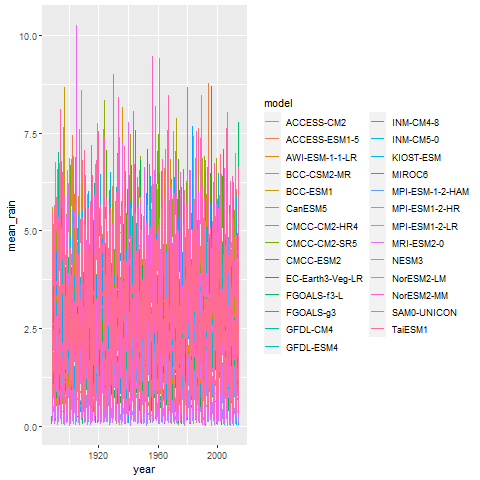

CPU times: total: 1.8 s
Wall time: 1.87 s


In [9]:
%%time
%%R
library(ggplot2)
start_time <- Sys.time()
plot <- summ_rain_2 %>% ggplot(aes(x = year, y = mean_rain, color = model)) + geom_line()
end_time <- Sys.time()
print(end_time - start_time)
plot

Time difference of 0.003999949 secs


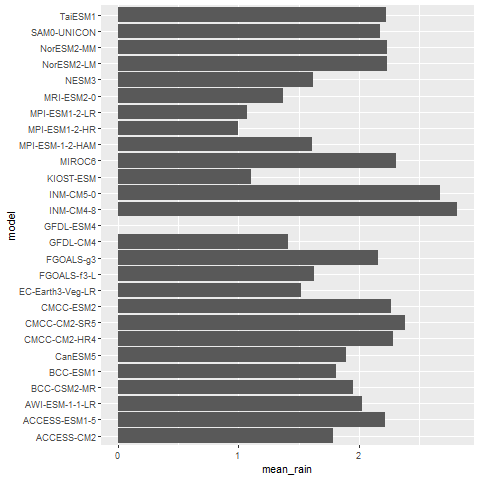

CPU times: total: 188 ms
Wall time: 205 ms


In [10]:
%%time
%%R
library(ggplot2)
start_time <- Sys.time()
plot2 <- summ_rain %>% ggplot(aes(x = mean_rain, y = model)) + geom_bar(stat = "identity")
end_time <- Sys.time()
print(end_time - start_time)
plot2

**<center>Plotting Times Comparison</center>**

| Team Member | Operating System | RAM | Processor | Is SSD | Time Taken (Plot1) | Time Taken (Plot2) |
|-------------|------------------|-----|-----------|--------|--------------------|--------------------|
| Jessie      | Windows 10 Education |  16GB     | Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz 1.99 GHz       |   Yes    | 1.55s | 1.14s  |
| Adrianne    | Windows 10 Pro       |  16GB     | Intel(R) Core(TM) i7-1165G7 @ 2.80GHz 2.80 GHz          |   Yes    | 1.28s | 0.139s |
| Rada        | Macbook Pro 2013 15" |  16GB     | 2.3 GHz Intel Core i7                                   |   No     | 1.22s | 1.43s  |
| Moid        | Windows 11 Education |  12GB     | 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz 1.38 GHz |   Yes    | 1.8s  | 188ms  |

## Observations Summary

### File manipulation:  

Downloading and unzipping the rainfall file took 6-11sec, with Windows machines fairing better than the Macbook.

Combining the data by simple concatenation took about 7-8min. Windows 10 Edu machine took the longest, but Macbook pro and Windows i5 core had a scary high peak memory at about 1/4 of its total RAM. Another interesting thing to note is the memory increment on an Windows i5 core machine is double of that on an i7 core.

### Loading Data into R:

We attempted several methods of loading the data into R, after previous work in pandas.   
Loading only the columns we needed reduced loading times from raw of a bit over 1min to ~5sec. Loading using more suited memory-smart data types of float32 instead of float64 cut loading time roughly in half.

Raw **Pandas exchange** took a very long time to load the data, upwards of 40 minutes for each of us and it failed to run on Moid's laptop by giving a 'memory exhausted' error.  
This baseline looked intimidating. Fortunately, every alternative method improved the processing time significantly.   

**Arrow** exchange ~26, **Feather** loading ~8sec, **Parquet** ~11sec and **partitioned Parquet** which comes with some more optimization ~35sec.   
And this is for a very large file with upwards of 62 million observations. Parquet is clearly a very good tool for loading the data. However, the Feather file read in failed to execute on Moid's laptop and constantly crashed the kernel. 

With that in mind, for files of this magnitude in the future, we would lean loading the data using **Parquet**, because it's optimized for working with large files and is comparable with alternative techniques.

### EDA Comparisons

Different file loading techniques resulted in various time savings for the purposes of simple EDA computing value counts.   
When loaded with **Arrow**, counting took ~53sec, with **Feather** ~20sec, with **Paraquet** ~10sec. Again, **Parquet** is proving to be a good tool for this kind of processing.

For the extraction of year/month from date, times varied a lot based on the run, but overall Pandas took ~30-90sec and R took ~20-30sec.
For the simple aggregation process, Pandas took ~6-10sec, and R took ~3-5sec to perform the same operation.
Plotting process was simple and fast despite once the data was aggregated, 1-3sec per plot for both Pandas and R. Of course, plotting usually requires aggregation in the first place: it's rare that the user will be able to make sense of millions of data points of non-aggregated data. So really, the aggregation times are more important to quantify here, because it is unlikely that plotting of millions of points will ever come up in practice.


### Machine Comparison Overall: 

In general, we didn't have a particularly wide variety of machine: each of us are on a 16GB RAM and Intel core.   
We did have both Macbook and Windows machines to test the results.   
It appears that the times are fairly consistent between operating systems.
In fact, while we only recorded final times and memory usages for each step per laptop, rerunning the notebook several times resulted in similar variation in times and memory usage to what we got from using different laptops.   
However, for most of the processes, Macbook machine was performing worse than others. A lot more tests on similar computers would need to be performed to get meaningful performance comparison because the Macbook is very old (2013) so besides the components of the build, wear and tear could affect the process timing